In [1]:
import pandas as pd
import numpy as np
df_train_filtered = pd.read_pickle('./data/df_train_filtered.pkl')


In [2]:
from sklearn.model_selection import train_test_split

X = df_train_filtered.drop('Hinta', axis=1)
y = df_train_filtered['Hinta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=df_train_filtered['Kaupunginosa'], random_state=42)





In [3]:
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

def rmsle_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true+1), np.log1p(y_pred+1)))

In [4]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean squared error: {mse:.2f}\nMean absolute error: {mae:.2f}\nR²-arvo: {r2:.2f}\nRMSLE: {rmsle_score(y_test, predictions):.2f}")


Mean squared error: 9450.37
Mean absolute error: 68.02
R²-arvo: 0.63
RMSLE: 0.32


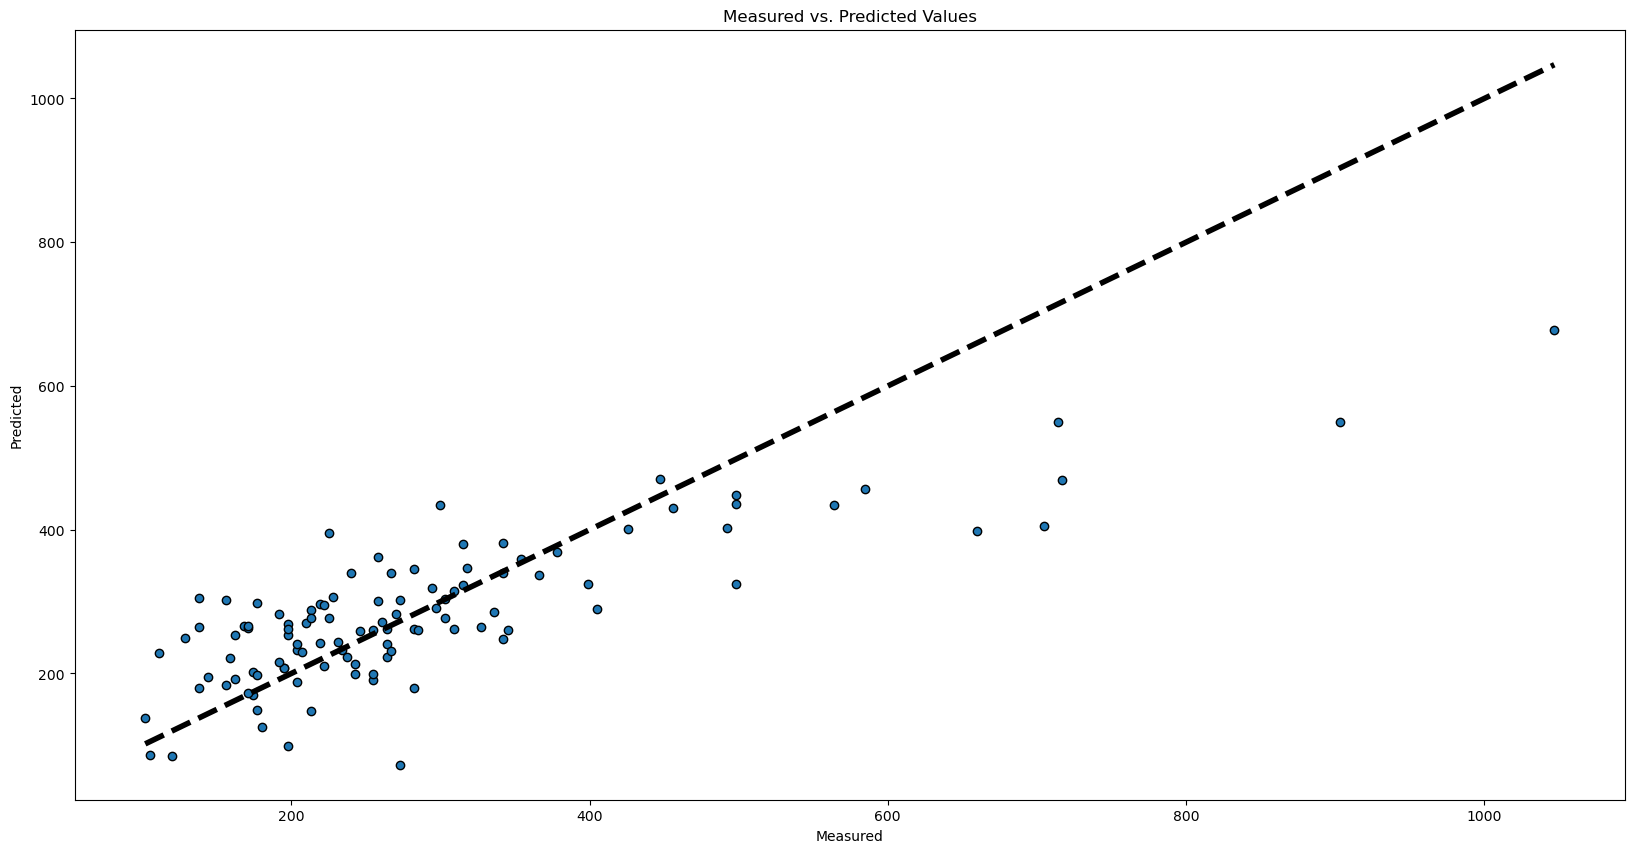

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Measured vs. Predicted Values')
plt.show()


/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-03-24 19:32:36,758] A new study created in memory with name: no-name-4455bf32-9a1b-4275-bd98-85849a15cd2a
[I 2024-03-24 19:32:41,180] Trial 0 finished with value: 0.29666142487315816 and parameters: {'objective': 'reg:absoluteerror', 'max_depth': 7, 'learning_rate': 0.355485505215724, 'subsample': 0.9589269078996532, 'colsample_bytree': 0.7128649608197177, 'gamma': 9.845844505617183, 'reg_alpha': 0.17865389307926138, 'reg_lambda': 4.035914447516133, 'num_boost_round': 274}. Best is trial 0 with value: 0.29666142487315816.
[I 2024-03-24 19:32:46,398] Trial 1 finished with value: 0.4187026803017103 and parameters: {'objective': 'reg:absoluteerror', 'max_depth': 5, 'learning_rate': 0.006538434979730285, 'subsample': 0.59

Best trial: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.06704097432635425, 'subsample': 0.9633335764808038, 'colsample_bytree': 0.8286350259554052, 'gamma': 1.9291104174375011, 'reg_alpha': 0.3701396452922299, 'reg_lambda': 5.266125198875791, 'num_boost_round': 519}
[19:34:06] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

MAE: 29.07608003969546, MSE: 2157.986086082939, RMSLE: 0.1428461760932788, R2: 0.9148319238011182


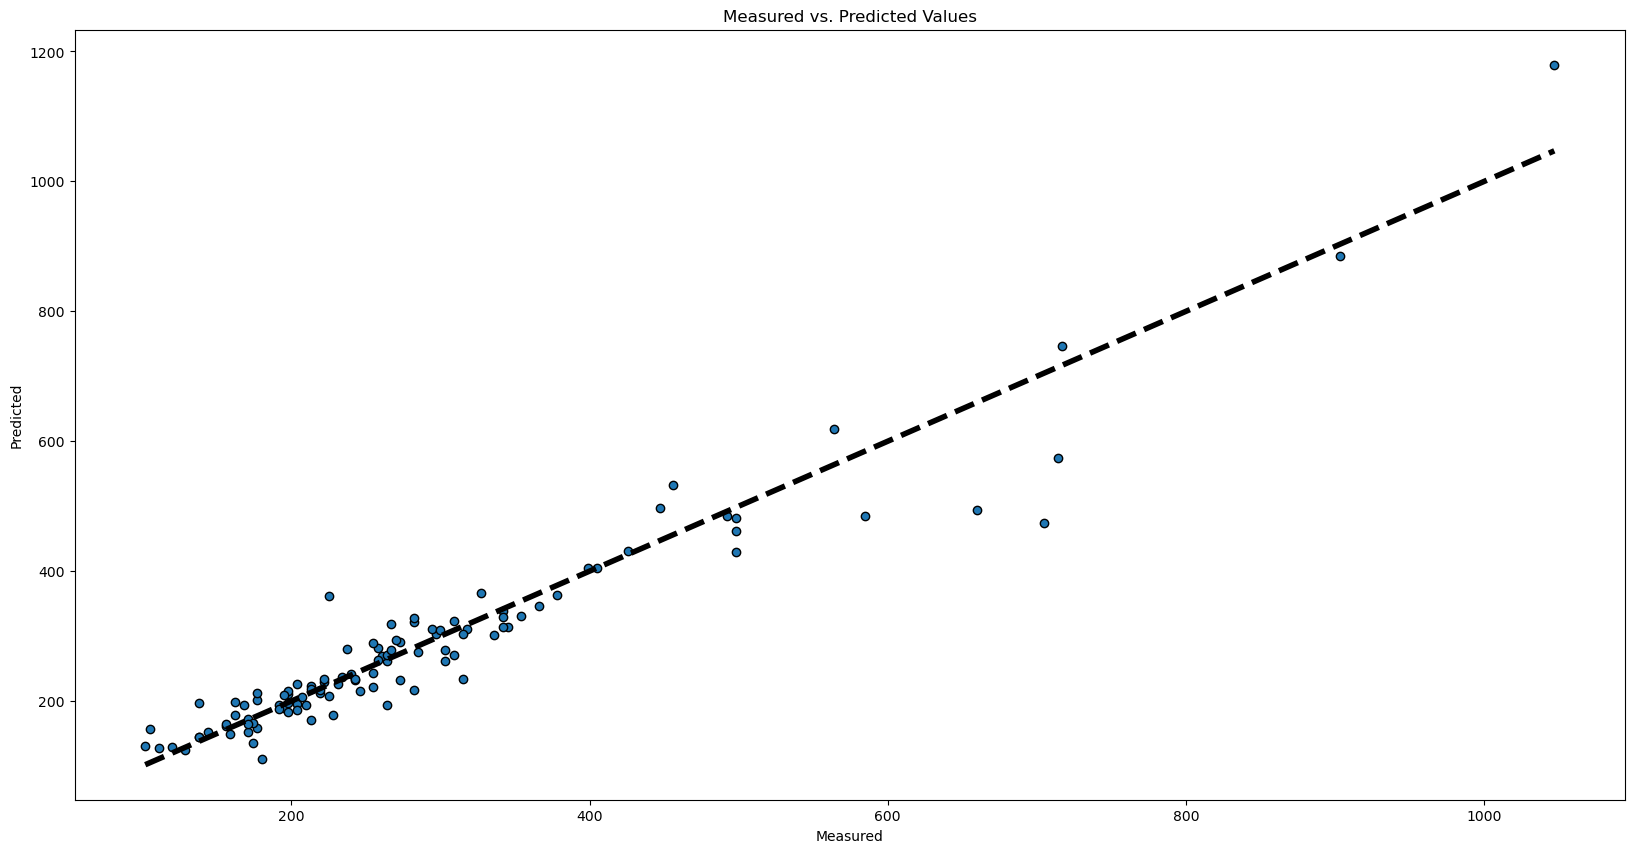

<Figure size 1000x600 with 0 Axes>

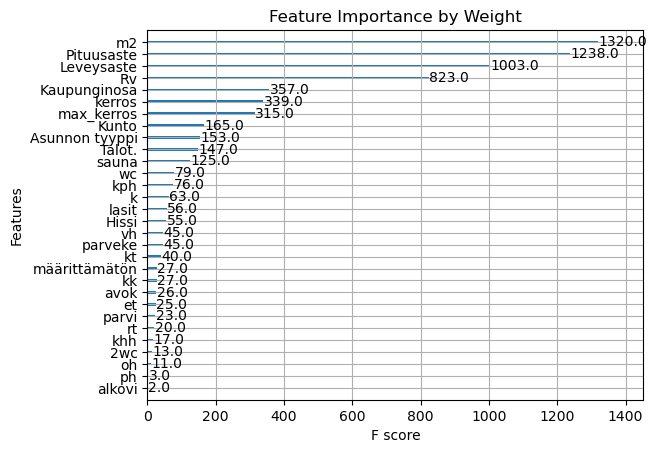

<Figure size 1000x600 with 0 Axes>

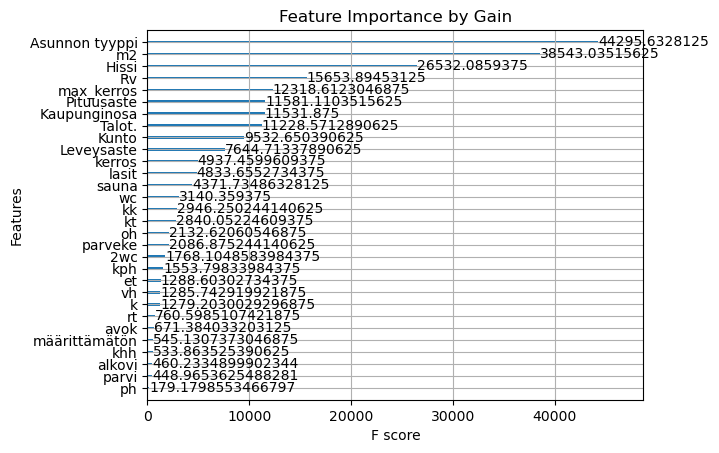

<Figure size 1000x600 with 0 Axes>

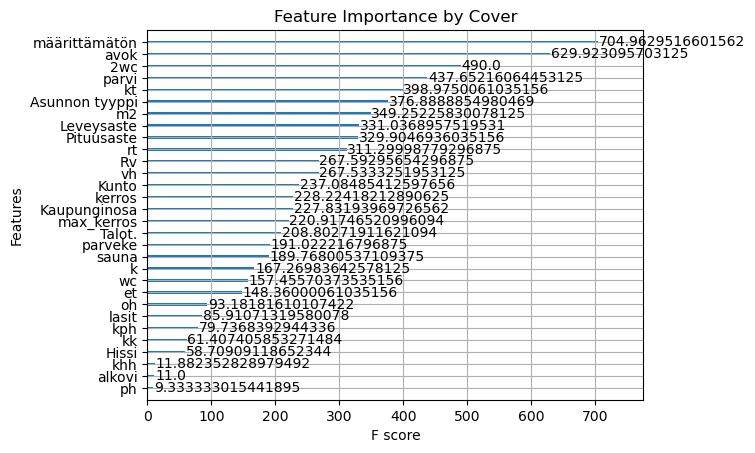

In [6]:
import optuna
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import time

def rmsle(y_true, y_pred):
    if np.any(y_pred <= 0):
        return 1e6
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

original_feature_names = list(X_train.columns) 
y_train_alku = np.array(y_train)
X_train_alku = np.array(X_train)

def objective(trial):
    params = {
        'objective': trial.suggest_categorical('objective', ['reg:squarederror', 'reg:absoluteerror']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
    }

    rmsle_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X_train):
        X_train_k, X_val_k = X_train_alku[train_index], X_train_alku[val_index]
        y_train_k, y_val_k = y_train_alku[train_index], y_train_alku[val_index]

        dtrain = xgb.DMatrix(X_train_k, label=y_train_k, feature_names=original_feature_names)
        dval = xgb.DMatrix(X_val_k, label=y_val_k, feature_names=original_feature_names)

        bst = xgb.train(params, dtrain, num_boost_round=trial.suggest_int('num_boost_round', 10, 1000, log=True),
                        evals=[(dval, 'eval')], early_stopping_rounds=50, verbose_eval=False)
        preds = bst.predict(dval)
        rmsle_score = rmsle(y_val_k, preds)
        rmsle_scores.append(rmsle_score)

    average_rmsle = np.mean(rmsle_scores)
    return average_rmsle

study = optuna.create_study(direction='minimize', storage = 'sqlite:///xgboost.db', study_name='xgboost_baseline0')
study.optimize(objective, n_trials=100)

print(f"Best trial: {study.best_trial.params}")

# Koulutetaan malli parhailla hyperparametreilla uudelleen koko datasetilla
best_params = study.best_trial.params
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=original_feature_names)
best_model = xgb.train(best_params, dtrain, num_boost_round=best_params['num_boost_round'])

dtest = xgb.DMatrix(X_test, label=y_test, feature_names=original_feature_names)
predictions = best_model.predict(dtest)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmsle_val = rmsle(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae}, MSE: {mse}, RMSLE: {rmsle_val}, R2: {r2}")

# Visualisointi
plt.figure(figsize=(20, 10))
plt.scatter(y_test, predictions, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs. Predicted Values')
plt.show()

# Feature importance
plt.figure(figsize=(15, 30))
xgb.plot_importance(best_model, importance_type='weight', title='Feature Importance by Weight')
plt.show()


plt.figure(figsize=(15, 30))
xgb.plot_importance(best_model, importance_type='gain', title='Feature Importance by Gain')
plt.show()

plt.figure(figsize=(15, 30))
xgb.plot_importance(best_model, importance_type='cover', title='Feature Importance by Cover')
plt.show()




In [7]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler 

# Skaalataan numeeriset muuttujat
robust_scaler = RobustScaler()
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
df_train_NN = df_train_filtered.copy()
df_train_NN[['Pituusaste', 'Leveysaste']] = minmax_scaler.fit_transform(df_train_NN[['Pituusaste', 'Leveysaste']])
df_train_NN['Rv'] = minmax_scaler.fit_transform(df_train_NN[['Rv']])
df_train_NN['m2'] = minmax_scaler.fit_transform(df_train_NN[['m2']])

# One hot koodataan kategoriset muuttujat
df_hot = pd.get_dummies(df_train_NN['Kaupunginosa'], prefix='Kaupunginosa').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['kerros'], prefix='kerros').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['max_kerros'], prefix='max_kerros').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['Kunto'], prefix='Kunto').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['Hissi'], prefix='Hissi').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['Asunnon tyyppi'], prefix='Asunnon tyyppi').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN["Talot."], prefix='Talot.').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)


df_train_NN.drop(['Kaupunginosa', 'kerros', 'max_kerros', 'Kunto', 'Hissi', 'Asunnon tyyppi', "Talot."], axis=1, inplace=True)




In [8]:
# Muodostetaan X ja y sekä jaetaan data harjoitus- ja testijoukkoihin

X = df_train_NN.drop('Hinta', axis=1)
y = df_train_NN['Hinta']

X = X.to_numpy()
y = y.to_numpy().astype('float32')

X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X, y, test_size=0.1, random_state=42, stratify=df_train_filtered['Kaupunginosa'])

In [9]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import time 
from optuna.integration import TFKerasPruningCallback
import os 
import pickle 
from datetime import timedelta


# Haun nimi
study_name = 'tampere_rmsle5'
# Montako osittelua käytettiin
folds = 5
# Montako epochia kullekin osittelulle
epochs_search = 100
# Montako satunnaista hakua kieroksella
num_random = 42
# Montako TPE hakua kieroksella
num_tpe = 42

# Aika sekuntteina jota hakuun käytetän
max_search_time = 21600
# Neuroneiden maksimimäärä 
max_units = 512

def rmsle_loss(y_true, y_pred):
    # Asetetaan suuri rangaistusarvo, jos y_pred sisältää arvon nolla tai alle
    penalty = tf.constant(1e5, dtype=tf.float32)
    
    # Maski, joka on tosi, kun y_pred on > 0
    valid_mask = tf.math.greater(y_pred, 0.0)
    
    # Käytä maskia valitsemaan joko oikea RMSLE laskenta tai suuri rangaistus
    safe_y_pred = tf.where(valid_mask, y_pred, penalty)
    
    # Laske RMSLE vain, jos y_pred on suurempi kuin 0, muuten palauta rangaistus
    rmsle = tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(safe_y_pred) - tf.math.log1p(y_true))))
    
    # Palauta suuri rangaistus, jos y_pred sisälsi nollan tai negatiivisen arvon
    return tf.where(tf.reduce_any(~valid_mask), penalty, rmsle)


def create_model(trial):
        
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(X_train_NN.shape[1],)))
    
    n_layers = trial.suggest_int('n_layers', 1, 3)
    max_units_previous_layer = max_units
    
    for i in range(n_layers):
        num_units = trial.suggest_int(f'n_units_{i}', 4, min(max_units_previous_layer, 512))
        max_units_previous_layer = num_units
        
        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.5)
        kernel_regularizer=regularizers.l1_l2(
            l1= trial.suggest_float(f'l1_reg_{i}', 1e-6, 1, log=True),
            l2= trial.suggest_float(f'l2_reg_{i}', 1e-6, 1, log=True)
        )

        activation = trial.suggest_categorical(f'activation_{i}', ['relu', 'tanh', 'selu', 'linear', 'sigmoid', 'elu'])
        
        model.add(keras.layers.Dense(num_units, activation=activation, kernel_regularizer=kernel_regularizer))    
        model.add(keras.layers.Dropout(rate=dropout_rate))
    
    num_last = trial.suggest_int('n_units_last', 1, 16)
    dropout_last = trial.suggest_float('dropout_last', 0.0, 0.5)
    activation_last = trial.suggest_categorical('activation_last', ['relu', 'tanh', 'selu', 'linear', 'sigmoid', 'elu'])
    kernel_regularizer_last = regularizers.l1_l2( 
        l1= trial.suggest_float('l1_reg_last', 1e-6, 1, log=True),
        l2= trial.suggest_float('l2_reg_last', 1e-6, 1, log=True)
    )
    model.add(keras.layers.Dense(num_last, activation=activation_last, kernel_regularizer=kernel_regularizer_last))        
    model.add(keras.layers.Dropout(rate=dropout_last))
    model.add(keras.layers.Dense(1, activation='linear')) 
    
    # Optimisaattorin ja oppimisnopeuden valinta
    optimizer_options = ['adam', 'rmsprop', 'Nadam', 'adamax', 'Adagrad', 'Adadelta']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    learning_rate = trial.suggest_float('lr', 1e-4, 1.0, log=True)
    
    if optimizer_selected == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_selected == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Nadam':
        optimizer = optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer_selected == 'Adagrad':
        optimizer = optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_selected == 'Adadelta':
        optimizer = optimizers.Adadelta(learning_rate=learning_rate)
    else:
        optimizer = optimizers.Adamax(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=rmsle_loss, metrics=['mse', 'mae'])
    
    return model

def objective(trial):

    model = create_model(trial)
    batch_size = trial.suggest_int('batch_size', 16, 128, log=True)    
    callbacks = [TFKerasPruningCallback(trial, 'val_loss'),
                 ReduceLROnPlateau('val_loss', patience=5, factor=0.7), 
                 TerminateOnNaN()]

    history = model.fit(X_train_b, y_train_b, epochs=epochs_search, validation_data=(X_val_b, y_val_b) ,batch_size=batch_size, verbose=0, callbacks=callbacks)
    val_loss = np.min(history.history['val_loss'])
    
    return val_loss




total_time_start = time.time()  
search_time_start = time.time() 
num_completed_trials = 0
search_rounds = 0
time_taken = 0
while time_taken < max_search_time:
        
    fold = 0 
    kf = KFold(n_splits=folds)
    
    time_fold_start = time.time()    
    for train_index, val_index in kf.split(X_train_NN):

        print('-------------------')
        print(f"Starting fold {fold} search...")
        X_train_b, X_val_b = X_train_NN[train_index], X_train_NN[val_index]    
        y_train_b, y_val_b = y_train_NN[train_index], y_train_NN[val_index]

        fold_name = f'{study_name}_{fold}'
       
        study = optuna.create_study(direction='minimize',
                                    pruner=optuna.pruners.HyperbandPruner(min_resource=5),
                                    study_name=fold_name,
                                    storage=f'sqlite:///tampere_reg.db',
                                    load_if_exists=True                                 
                                    )

        fold_time = time.time()    

        fold_random = time.time()
        study.sampler = optuna.samplers.RandomSampler()
        print(f'Random search for fold {fold}...')
        study.optimize(objective, n_trials=num_random)
        print(f'Time taken for random search: {str(timedelta(seconds=(time.time() - fold_random)))}')

        fold_tpe = time.time()  
        study.sampler = optuna.samplers.TPESampler(n_startup_trials=0, n_ei_candidates=30, consider_endpoints=True)
        print(f'TPE search for fold {fold}...')
        study.optimize(objective, n_trials=num_tpe)
        print(f'Time taken for TPE search: {str(timedelta(seconds=(time.time() - fold_tpe)))}')

        num_completed_trials += num_random + num_tpe
        print('-------------------')
        print(f'Finished fold {fold} search.')
        print(f"Time taken for this fold: {str(timedelta(seconds=(time.time() - fold_time)))}")                
        print(f'Fold {fold} best value so far: {study.best_value}')
        print(f'Mean time for one trial this fold: {str(timedelta(seconds=(time.time() - fold_time) / (num_random + num_tpe)))}')

        fold += 1
    search_rounds += 1
    
    time_taken = time.time() - search_time_start
    
    print(f'\n# Completed search round: {search_rounds} #')
    print(f'Time taken for all folds this round: {str(timedelta(seconds=(time.time() - time_fold_start)))}')
    print(f'Total time taken for search: {str(timedelta(seconds=(time.time() - search_time_start)))}')
    print(f'Made trials this far: {num_completed_trials}')
    print(f"Current mean time for one trial: {str(timedelta(seconds=(time.time() - search_time_start) / num_completed_trials))}\n")
    

print('='*20)    
print(f'Finished search.')    
print(f'Total time taken for all folds: {str(timedelta(seconds=(time.time() - search_time_start)))}')
print(f'Made {num_completed_trials} trials in total.')
print(f"Mean time for one trial: {str(timedelta(seconds=(time.time() - search_time_start) / num_completed_trials))}")
print('='*20)




2024-03-24 19:34:08.190937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 19:34:08.788178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


-------------------
Starting fold 0 search...


[I 2024-03-24 19:34:09,613] Using an existing study with name 'tampere_rmsle5_0' instead of creating a new one.


Random search for fold 0...


2024-03-24 19:34:10.747916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 19:34:10.804088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 19:34:10.804153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 19:34:10.807036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 19:34:10.807109: I tensorflow/compile

Time taken for random search: 0:00:03.252908
TPE search for fold 0...


[I 2024-03-24 19:34:15,569] Trial 550 pruned. Trial was pruned at epoch 5.
[I 2024-03-24 19:34:15,598] Using an existing study with name 'tampere_rmsle5_1' instead of creating a new one.


Time taken for TPE search: 0:00:02.698889
-------------------
Finished fold 0 search.
Time taken for this fold: 0:00:05.951908
Fold 0 best value so far: 0.2259472757577896
Mean time for one trial this fold: 0:00:02.980419
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-24 19:34:18,436] Trial 506 pruned. Trial was pruned at epoch 15.


Time taken for random search: 0:00:02.831555
TPE search for fold 1...


[I 2024-03-24 19:34:56,885] Trial 507 finished with value: 0.43302643299102783 and parameters: {'n_layers': 1, 'n_units_0': 86, 'dropout_0': 0.18149148134339105, 'l1_reg_0': 3.1350540573200904e-05, 'l2_reg_0': 0.12428693199715013, 'activation_0': 'relu', 'n_units_last': 9, 'dropout_last': 0.11190593580996905, 'activation_last': 'linear', 'l1_reg_last': 6.125293692579503e-05, 'l2_reg_last': 0.1867873041738461, 'optimizer': 'adam', 'lr': 0.038527282340738093, 'batch_size': 16}. Best is trial 185 with value: 0.21225786209106445.
[I 2024-03-24 19:34:56,911] Using an existing study with name 'tampere_rmsle5_2' instead of creating a new one.


Time taken for TPE search: 0:00:38.448566
-------------------
Finished fold 1 search.
Time taken for this fold: 0:00:41.280230
Fold 1 best value so far: 0.21225786209106445
Mean time for one trial this fold: 0:00:20.642851
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-24 19:35:01,059] Trial 506 pruned. Trial was pruned at epoch 15.


Time taken for random search: 0:00:04.141301
TPE search for fold 2...


[I 2024-03-24 19:35:42,250] Trial 507 finished with value: 0.243540957570076 and parameters: {'n_layers': 3, 'n_units_0': 487, 'dropout_0': 0.28918980217157514, 'l1_reg_0': 0.00018110971445731597, 'l2_reg_0': 0.0037635030511685495, 'activation_0': 'elu', 'n_units_1': 440, 'dropout_1': 0.1880593939525143, 'l1_reg_1': 1.2840442989661432e-05, 'l2_reg_1': 7.94778529687751e-06, 'activation_1': 'selu', 'n_units_2': 430, 'dropout_2': 0.4776015391623168, 'l1_reg_2': 8.75007308361278e-05, 'l2_reg_2': 0.330674230503077, 'activation_2': 'tanh', 'n_units_last': 13, 'dropout_last': 0.0974964896235702, 'activation_last': 'selu', 'l1_reg_last': 2.853537455386988e-06, 'l2_reg_last': 1.3960230892298702e-06, 'optimizer': 'adam', 'lr': 0.011391306583772484, 'batch_size': 21}. Best is trial 441 with value: 0.2231494039297104.
[I 2024-03-24 19:35:42,277] Using an existing study with name 'tampere_rmsle5_3' instead of creating a new one.


Time taken for TPE search: 0:00:41.190740
-------------------
Finished fold 2 search.
Time taken for this fold: 0:00:45.332253
Fold 2 best value so far: 0.2231494039297104
Mean time for one trial this fold: 0:00:22.668798
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-24 19:35:46,107] Trial 506 pruned. Trial was pruned at epoch 15.


Time taken for random search: 0:00:03.823272
TPE search for fold 3...


[I 2024-03-24 19:35:54,885] Trial 507 pruned. Trial was pruned at epoch 45.
[I 2024-03-24 19:35:54,916] Using an existing study with name 'tampere_rmsle5_4' instead of creating a new one.


Time taken for TPE search: 0:00:08.778014
-------------------
Finished fold 3 search.
Time taken for this fold: 0:00:12.601393
Fold 3 best value so far: 0.22962994873523712
Mean time for one trial this fold: 0:00:06.303815
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-24 19:36:05,332] Trial 506 pruned. Trial was pruned at epoch 45.


Time taken for random search: 0:00:10.409403
TPE search for fold 4...


[I 2024-03-24 19:36:48,800] Trial 507 finished with value: 0.4011348783969879 and parameters: {'n_layers': 3, 'n_units_0': 31, 'dropout_0': 0.1595833505583095, 'l1_reg_0': 2.1217784305878316e-06, 'l2_reg_0': 0.010683790659884332, 'activation_0': 'relu', 'n_units_1': 5, 'dropout_1': 0.03428203212838889, 'l1_reg_1': 0.001658638920745928, 'l2_reg_1': 0.0004270729222980029, 'activation_1': 'elu', 'n_units_2': 4, 'dropout_2': 0.1297801528920458, 'l1_reg_2': 0.005770764948840279, 'l2_reg_2': 0.0439048610562686, 'activation_2': 'tanh', 'n_units_last': 2, 'dropout_last': 0.10131520390681782, 'activation_last': 'elu', 'l1_reg_last': 0.00014161486382599443, 'l2_reg_last': 0.0020877500339580276, 'optimizer': 'adam', 'lr': 0.3156491785690105, 'batch_size': 18}. Best is trial 190 with value: 0.2738736867904663.


Time taken for TPE search: 0:00:43.467379
-------------------
Finished fold 4 search.
Time taken for this fold: 0:00:53.876892
Fold 4 best value so far: 0.2738736867904663
Mean time for one trial this fold: 0:00:26.941055

# Completed search round: 1 #
Time taken for all folds this round: 0:02:39.511052
Total time taken for search: 0:02:39.511331
Made trials this far: 10
Current mean time for one trial: 0:00:15.951134

Finished search.
Total time taken for all folds: 0:02:39.511538
Made 10 trials in total.
Mean time for one trial: 0:00:15.951160


In [10]:
from datetime import timedelta
from sklearn.model_selection import train_test_split, KFold
import optuna
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import time 
from optuna.integration import TFKerasPruningCallback
import os 
import pickle 

folds = 5
# Montako epochia kullekin parhaalle sovitetaan malli
epochs_best_fit = 500
# Montako paras otetaan mukaan osittelusta
num_best = 10
# Montako kertaa kullekin parhaalle sovitetaan malli
num_best_fits = 1

best_optuna_models = []
best_val_scores = []
best_optuna_trials = [] 

kf = KFold(n_splits=folds)
fold_num = 0
fitting_search_start = time.time()

for train_index, val_index in kf.split(X_train_NN):

    best_fitting_time = time.time()
    print(f"Fold {fold_num} Best best trial fitting...")

    X_train_b, X_val_b = X_train_NN[train_index], X_train_NN[val_index]    
    y_train_b, y_val_b = y_train_NN[train_index], y_train_NN[val_index]
    
    fold_name = f'{study_name}_{fold_num}'
       
    study = optuna.create_study(                                
                                study_name=fold_name,
                                storage=f'sqlite:///tampere_reg.db',
                                load_if_exists=True
                                )

    sorted_trials = sorted(study.trials, key=lambda trial: trial.value)
    best_trials = sorted_trials[:num_best]
    best_val = np.inf
    best_model = None

    print('='*30)
    print(f'Fitting best trials for fold {fold_num}...')
    fitting_fold_best_start = time.time()
    
    for trial in best_trials:

        print(f'Trial val_loss:{trial.value}\nhyperparameters: {trial.params}')

        for fit_num in range(num_best_fits):
            
            print('-'*30)
            print(f"Trial ID: {trial.number}, Value: {trial.value}, fit number: {fit_num}")

            checkpoint_filepath = f'./NN_search/optuna_search_checkpoint.h5'
            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_loss',
                mode='min',
                save_best_only=True)

            best_callback = [model_checkpoint_callback,                  
                            ReduceLROnPlateau('val_loss', patience=10, factor=0.8), 
                            TerminateOnNaN(),
                            EarlyStopping(monitor='val_loss', patience=100, verbose=1)
                        ]


            model = create_model(trial)
            model.fit(X_train_b, y_train_b, epochs=epochs_best_fit, validation_data=(X_val_b, y_val_b), batch_size=trial.params['batch_size'], verbose=0, callbacks=best_callback)
            model.load_weights(checkpoint_filepath)

            predictions = model.predict(X_val_b, verbose=0)
            mse = mean_squared_error(y_val_b, predictions)
            mae = mean_absolute_error(y_val_b, predictions)
            r2 = r2_score(y_val_b, predictions)
            rmsle = rmsle_score(y_val_b, predictions)

                        
            print(f'MSE:{mse:.5f}\nMAE:{mae:.5f}\nRMSLE:{rmsle:.5f}\nR2:{r2:.5f}')

            if rmsle < best_val:
                best_model = model
                best_val = rmsle
                best_trial_num = trial.number
                best_trial = trial
                print(f'*** New best model for fold {fold_num} is Trial {best_trial_num} with RMSLE {best_val} ***')
                print(f'Best trial hyperparameters: {trial.params}')
    
    if best_model is not None:

        best_optuna_models.append(best_model)
        best_val_scores.append(best_val)
        best_optuna_trials.append(best_trial)
        print('='*30)
        print(f"Best model for fold {fold_num} RMSLE: {best_val}\nTrial number: {best_trial_num}\nHyperparameters: {best_trial.params}")
        print(f"Time taken for best fitting in fold {fold_num}: {str(timedelta(seconds=(time.time() - best_fitting_time)) )}")
        print('='*30)

    fold_num += 1

print('='*30)
print(f'Best models fitting time total:', str(timedelta(seconds=(time.time() - fitting_search_start))))
print(f"Total time taken for search and fitting best models: {str(timedelta(seconds=(time.time() - total_time_start)))}")
print('='*30)   

from datetime import datetime

for i, (model, score) in enumerate(zip(best_optuna_models, best_val_scores)):
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    directory = f"./NN_search/{study_name}_foldmodel{i}_score_{score:.4f}_{timestamp}.h5"
    print(f"Saving model {i} with score {score:.4f} to {directory}")
    model.save(directory)




[I 2024-03-24 19:36:48,847] Using an existing study with name 'tampere_rmsle5_0' instead of creating a new one.


Fold 0 Best best trial fitting...
Fitting best trials for fold 0...
Trial val_loss:0.2259472757577896
hyperparameters: {'n_layers': 1, 'n_units_0': 401, 'dropout_0': 0.42873647153126093, 'l1_reg_0': 1.0142024556180758e-06, 'l2_reg_0': 1.0468073013802187e-05, 'activation_0': 'linear', 'n_units_last': 14, 'dropout_last': 0.05999188374579369, 'activation_last': 'relu', 'l1_reg_last': 3.7971324169165166e-06, 'l2_reg_last': 1.2724084036290166e-06, 'optimizer': 'adam', 'lr': 0.00280747809579241, 'batch_size': 20}
------------------------------
Trial ID: 548, Value: 0.2259472757577896, fit number: 0
Epoch 171: early stopping


[I 2024-03-24 19:37:42,969] Using an existing study with name 'tampere_rmsle5_1' instead of creating a new one.


MSE:5123.23633
MAE:43.50328
RMSLE:0.21259
R2:0.67436
*** New best model for fold 0 is Trial 548 with RMSLE 0.21258942782878876 ***
Best trial hyperparameters: {'n_layers': 1, 'n_units_0': 401, 'dropout_0': 0.42873647153126093, 'l1_reg_0': 1.0142024556180758e-06, 'l2_reg_0': 1.0468073013802187e-05, 'activation_0': 'linear', 'n_units_last': 14, 'dropout_last': 0.05999188374579369, 'activation_last': 'relu', 'l1_reg_last': 3.7971324169165166e-06, 'l2_reg_last': 1.2724084036290166e-06, 'optimizer': 'adam', 'lr': 0.00280747809579241, 'batch_size': 20}
Best model for fold 0 RMSLE: 0.21258942782878876
Trial number: 548
Hyperparameters: {'n_layers': 1, 'n_units_0': 401, 'dropout_0': 0.42873647153126093, 'l1_reg_0': 1.0142024556180758e-06, 'l2_reg_0': 1.0468073013802187e-05, 'activation_0': 'linear', 'n_units_last': 14, 'dropout_last': 0.05999188374579369, 'activation_last': 'relu', 'l1_reg_last': 3.7971324169165166e-06, 'l2_reg_last': 1.2724084036290166e-06, 'optimizer': 'adam', 'lr': 0.002807

[I 2024-03-24 19:40:33,847] Using an existing study with name 'tampere_rmsle5_2' instead of creating a new one.


MSE:4595.35449
MAE:39.51551
RMSLE:0.19033
R2:0.79884
*** New best model for fold 1 is Trial 185 with RMSLE 0.19033215939998627 ***
Best trial hyperparameters: {'n_layers': 2, 'n_units_0': 10, 'dropout_0': 0.36508772975683784, 'l1_reg_0': 9.08184296427293e-06, 'l2_reg_0': 1.8481819168299449e-06, 'activation_0': 'elu', 'n_units_1': 9, 'dropout_1': 0.11664954869896021, 'l1_reg_1': 4.2595548060933646e-05, 'l2_reg_1': 5.0285817114383375e-05, 'activation_1': 'elu', 'n_units_last': 10, 'dropout_last': 0.2682185924468136, 'activation_last': 'linear', 'l1_reg_last': 1.391284498925647e-06, 'l2_reg_last': 0.0031654378595034173, 'optimizer': 'Nadam', 'lr': 0.01746242979690285, 'batch_size': 18}
Best model for fold 1 RMSLE: 0.19033215939998627
Trial number: 185
Hyperparameters: {'n_layers': 2, 'n_units_0': 10, 'dropout_0': 0.36508772975683784, 'l1_reg_0': 9.08184296427293e-06, 'l2_reg_0': 1.8481819168299449e-06, 'activation_0': 'elu', 'n_units_1': 9, 'dropout_1': 0.11664954869896021, 'l1_reg_1': 4.

[I 2024-03-24 19:42:49,272] Using an existing study with name 'tampere_rmsle5_3' instead of creating a new one.


MSE:5220.96729
MAE:45.63885
RMSLE:0.20074
R2:0.69873
*** New best model for fold 2 is Trial 441 with RMSLE 0.20074358582496643 ***
Best trial hyperparameters: {'n_layers': 1, 'n_units_0': 102, 'dropout_0': 0.32940861586937975, 'l1_reg_0': 0.00015344619036673188, 'l2_reg_0': 3.4761495162225135e-06, 'activation_0': 'linear', 'n_units_last': 12, 'dropout_last': 0.007821601978181658, 'activation_last': 'elu', 'l1_reg_last': 4.157968478902406e-06, 'l2_reg_last': 2.63449095603865e-06, 'optimizer': 'adamax', 'lr': 0.014209890442640056, 'batch_size': 19}
Best model for fold 2 RMSLE: 0.20074358582496643
Trial number: 441
Hyperparameters: {'n_layers': 1, 'n_units_0': 102, 'dropout_0': 0.32940861586937975, 'l1_reg_0': 0.00015344619036673188, 'l2_reg_0': 3.4761495162225135e-06, 'activation_0': 'linear', 'n_units_last': 12, 'dropout_last': 0.007821601978181658, 'activation_last': 'elu', 'l1_reg_last': 4.157968478902406e-06, 'l2_reg_last': 2.63449095603865e-06, 'optimizer': 'adamax', 'lr': 0.0142098

[I 2024-03-24 19:44:04,419] Using an existing study with name 'tampere_rmsle5_4' instead of creating a new one.


MSE:5723.97412
MAE:42.52714
RMSLE:0.19044
R2:0.76983
*** New best model for fold 3 is Trial 483 with RMSLE 0.19043686985969543 ***
Best trial hyperparameters: {'n_layers': 2, 'n_units_0': 113, 'dropout_0': 0.3284124966396315, 'l1_reg_0': 1.0231818421502702e-06, 'l2_reg_0': 1.2988021141650662e-06, 'activation_0': 'elu', 'n_units_1': 7, 'dropout_1': 0.24576151815954722, 'l1_reg_1': 0.000867061674698729, 'l2_reg_1': 0.001386460486123414, 'activation_1': 'sigmoid', 'n_units_last': 14, 'dropout_last': 0.11898465984369068, 'activation_last': 'linear', 'l1_reg_last': 1.7265578325587644e-06, 'l2_reg_last': 4.782080281164969e-06, 'optimizer': 'adam', 'lr': 0.019889561117143906, 'batch_size': 49}
Best model for fold 3 RMSLE: 0.19043686985969543
Trial number: 483
Hyperparameters: {'n_layers': 2, 'n_units_0': 113, 'dropout_0': 0.3284124966396315, 'l1_reg_0': 1.0231818421502702e-06, 'l2_reg_0': 1.2988021141650662e-06, 'activation_0': 'elu', 'n_units_1': 7, 'dropout_1': 0.24576151815954722, 'l1_reg_

In [11]:
for idx, model in enumerate(best_optuna_models):
    print(f"\nModel {idx} Summary:")
    # model.summary()
    
    # Testaa mallia testidatalla
    predictions = model.predict(X_test_NN, verbose = 0)
    mse = mean_squared_error(y_test_NN, predictions)
    mae = mean_absolute_error(y_test_NN, predictions)
    r2 = r2_score(y_test_NN, predictions)
    rmsle = rmsle_score(y_test_NN, predictions)
    
    print(f"\nModel {idx+1} Performance on Test Data:")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R2: {r2:.3f}")
    print(f"RMSLE: {rmsle:.3f}")
    print("="*80)





Model 0 Summary:

Model 1 Performance on Test Data:
MSE: 7163.955
MAE: 50.851
R2: 0.717
RMSLE: 0.218

Model 1 Summary:

Model 2 Performance on Test Data:
MSE: 4368.294
MAE: 41.614
R2: 0.828
RMSLE: 0.177

Model 2 Summary:

Model 3 Performance on Test Data:
MSE: 6106.976
MAE: 48.567
R2: 0.759
RMSLE: 0.200

Model 3 Summary:

Model 4 Performance on Test Data:
MSE: 4540.316
MAE: 39.683
R2: 0.821
RMSLE: 0.177

Model 4 Summary:

Model 5 Performance on Test Data:
MSE: 4139.080
MAE: 43.060
R2: 0.837
RMSLE: 0.198


Loaded best model for fold 0 from ./NN_search/tampere_rmsle5_foldmodel0_score_0.2126_20240324-194553.h5 with score 0.2126
Loaded best model for fold 1 from ./NN_search/tampere_rmsle5_foldmodel1_score_0.1903_20240324-194553.h5 with score 0.1903
Loaded best model for fold 2 from ./NN_search/tampere_rmsle5_foldmodel2_score_0.2007_20240324-194553.h5 with score 0.2007
Loaded best model for fold 3 from ./NN_search/tampere_rmsle5_foldmodel3_score_0.1904_20240324-194553.h5 with score 0.1904
Loaded best model for fold 4 from ./NN_search/tampere_rmsle5_foldmodel4_score_0.2227_20240324-194553.h5 with score 0.2227
4/4 [==============================] - 0s 2ms/step


[I 2024-03-24 20:22:37,438] Using an existing study with name 'tampere_xgb_combined_test_toka' instead of creating a new one.
[I 2024-03-24 20:22:46,825] Trial 100 finished with value: 0.42508881862203596 and parameters: {'objective': 'reg:absoluteerror', 'max_depth': 9, 'learning_rate': 0.00013353092224667888, 'subsample': 0.7003232494460404, 'colsample_bytree': 0.9969786372754653, 'gamma': 5.174314641639045, 'reg_alpha': 0.08730584899886555, 'reg_lambda': 8.353002143290075, 'num_boost_round': 351}. Best is trial 33 with value: 0.11768749264322984.
[I 2024-03-24 20:22:52,898] Trial 101 finished with value: 0.1192977129978873 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 0.0933615232744526, 'subsample': 0.6752035170847731, 'colsample_bytree': 0.9567720956001283, 'gamma': 5.736685765486301, 'reg_alpha': 0.06561511663087759, 'reg_lambda': 7.638484029758883, 'num_boost_round': 270}. Best is trial 33 with value: 0.11768749264322984.
[I 2024-03-24 20:23:

Time taken for XGBoost optimization: 0:01:02.741532
Time taken for one trial: 0:00:06.274169
Best trial: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.058128710730194, 'subsample': 0.5560169925277609, 'colsample_bytree': 0.8994759984176237, 'gamma': 6.971505435692311, 'reg_alpha': 0.0828738996158277, 'reg_lambda': 7.9418279814945905, 'num_boost_round': 545}
[20:23:38] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.



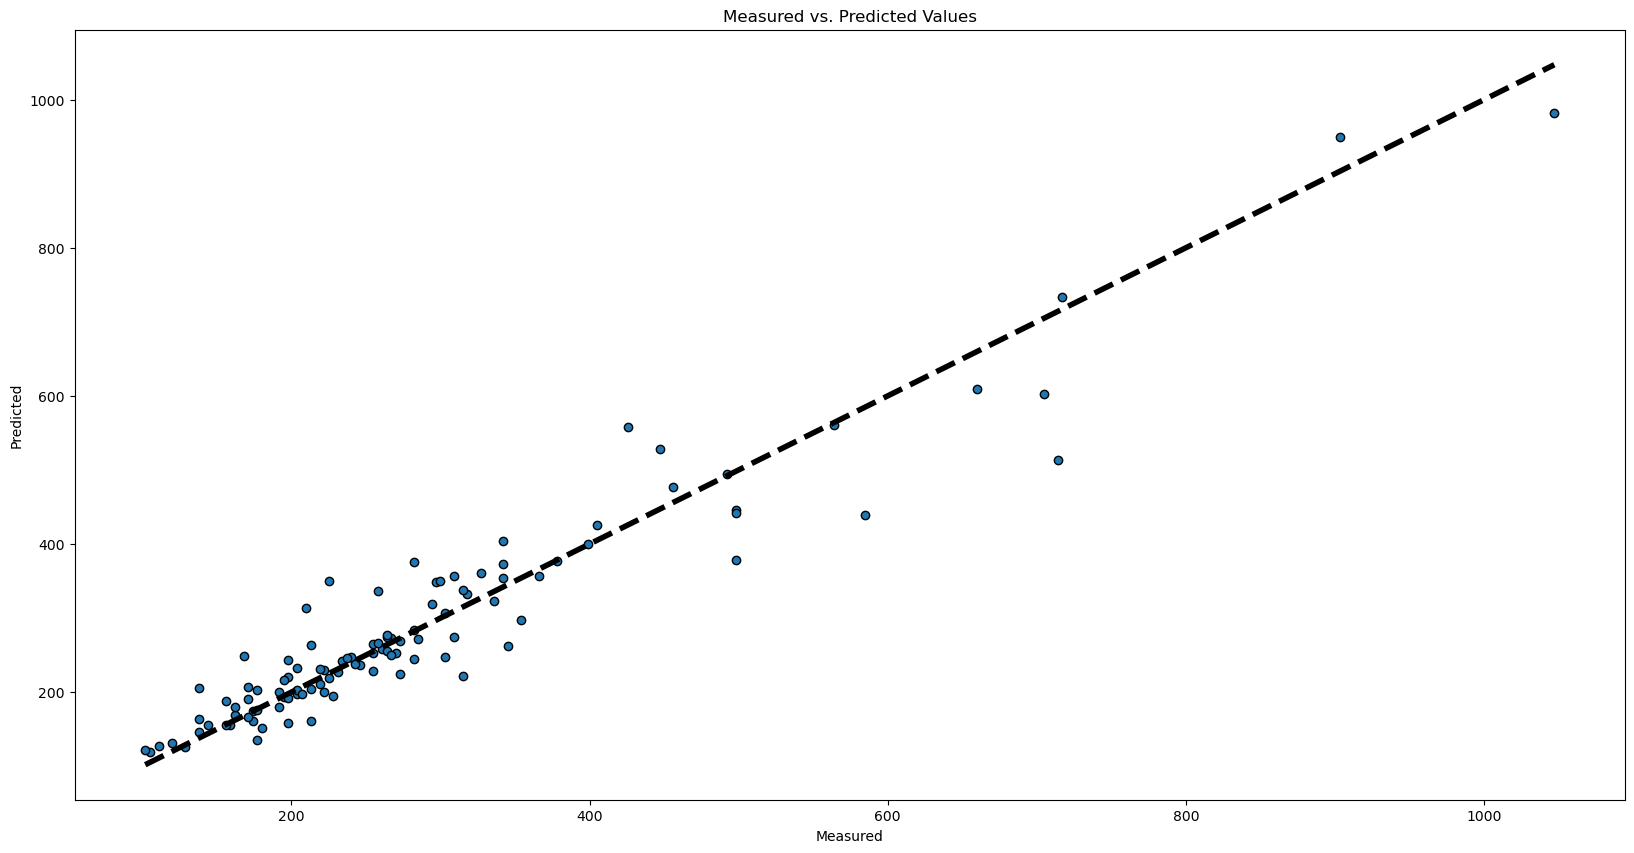

MAE: 31.326123202288592, MSE: 2265.5314518271075, R2: 0.910587488693957, RMSLE: 0.14897805732138183


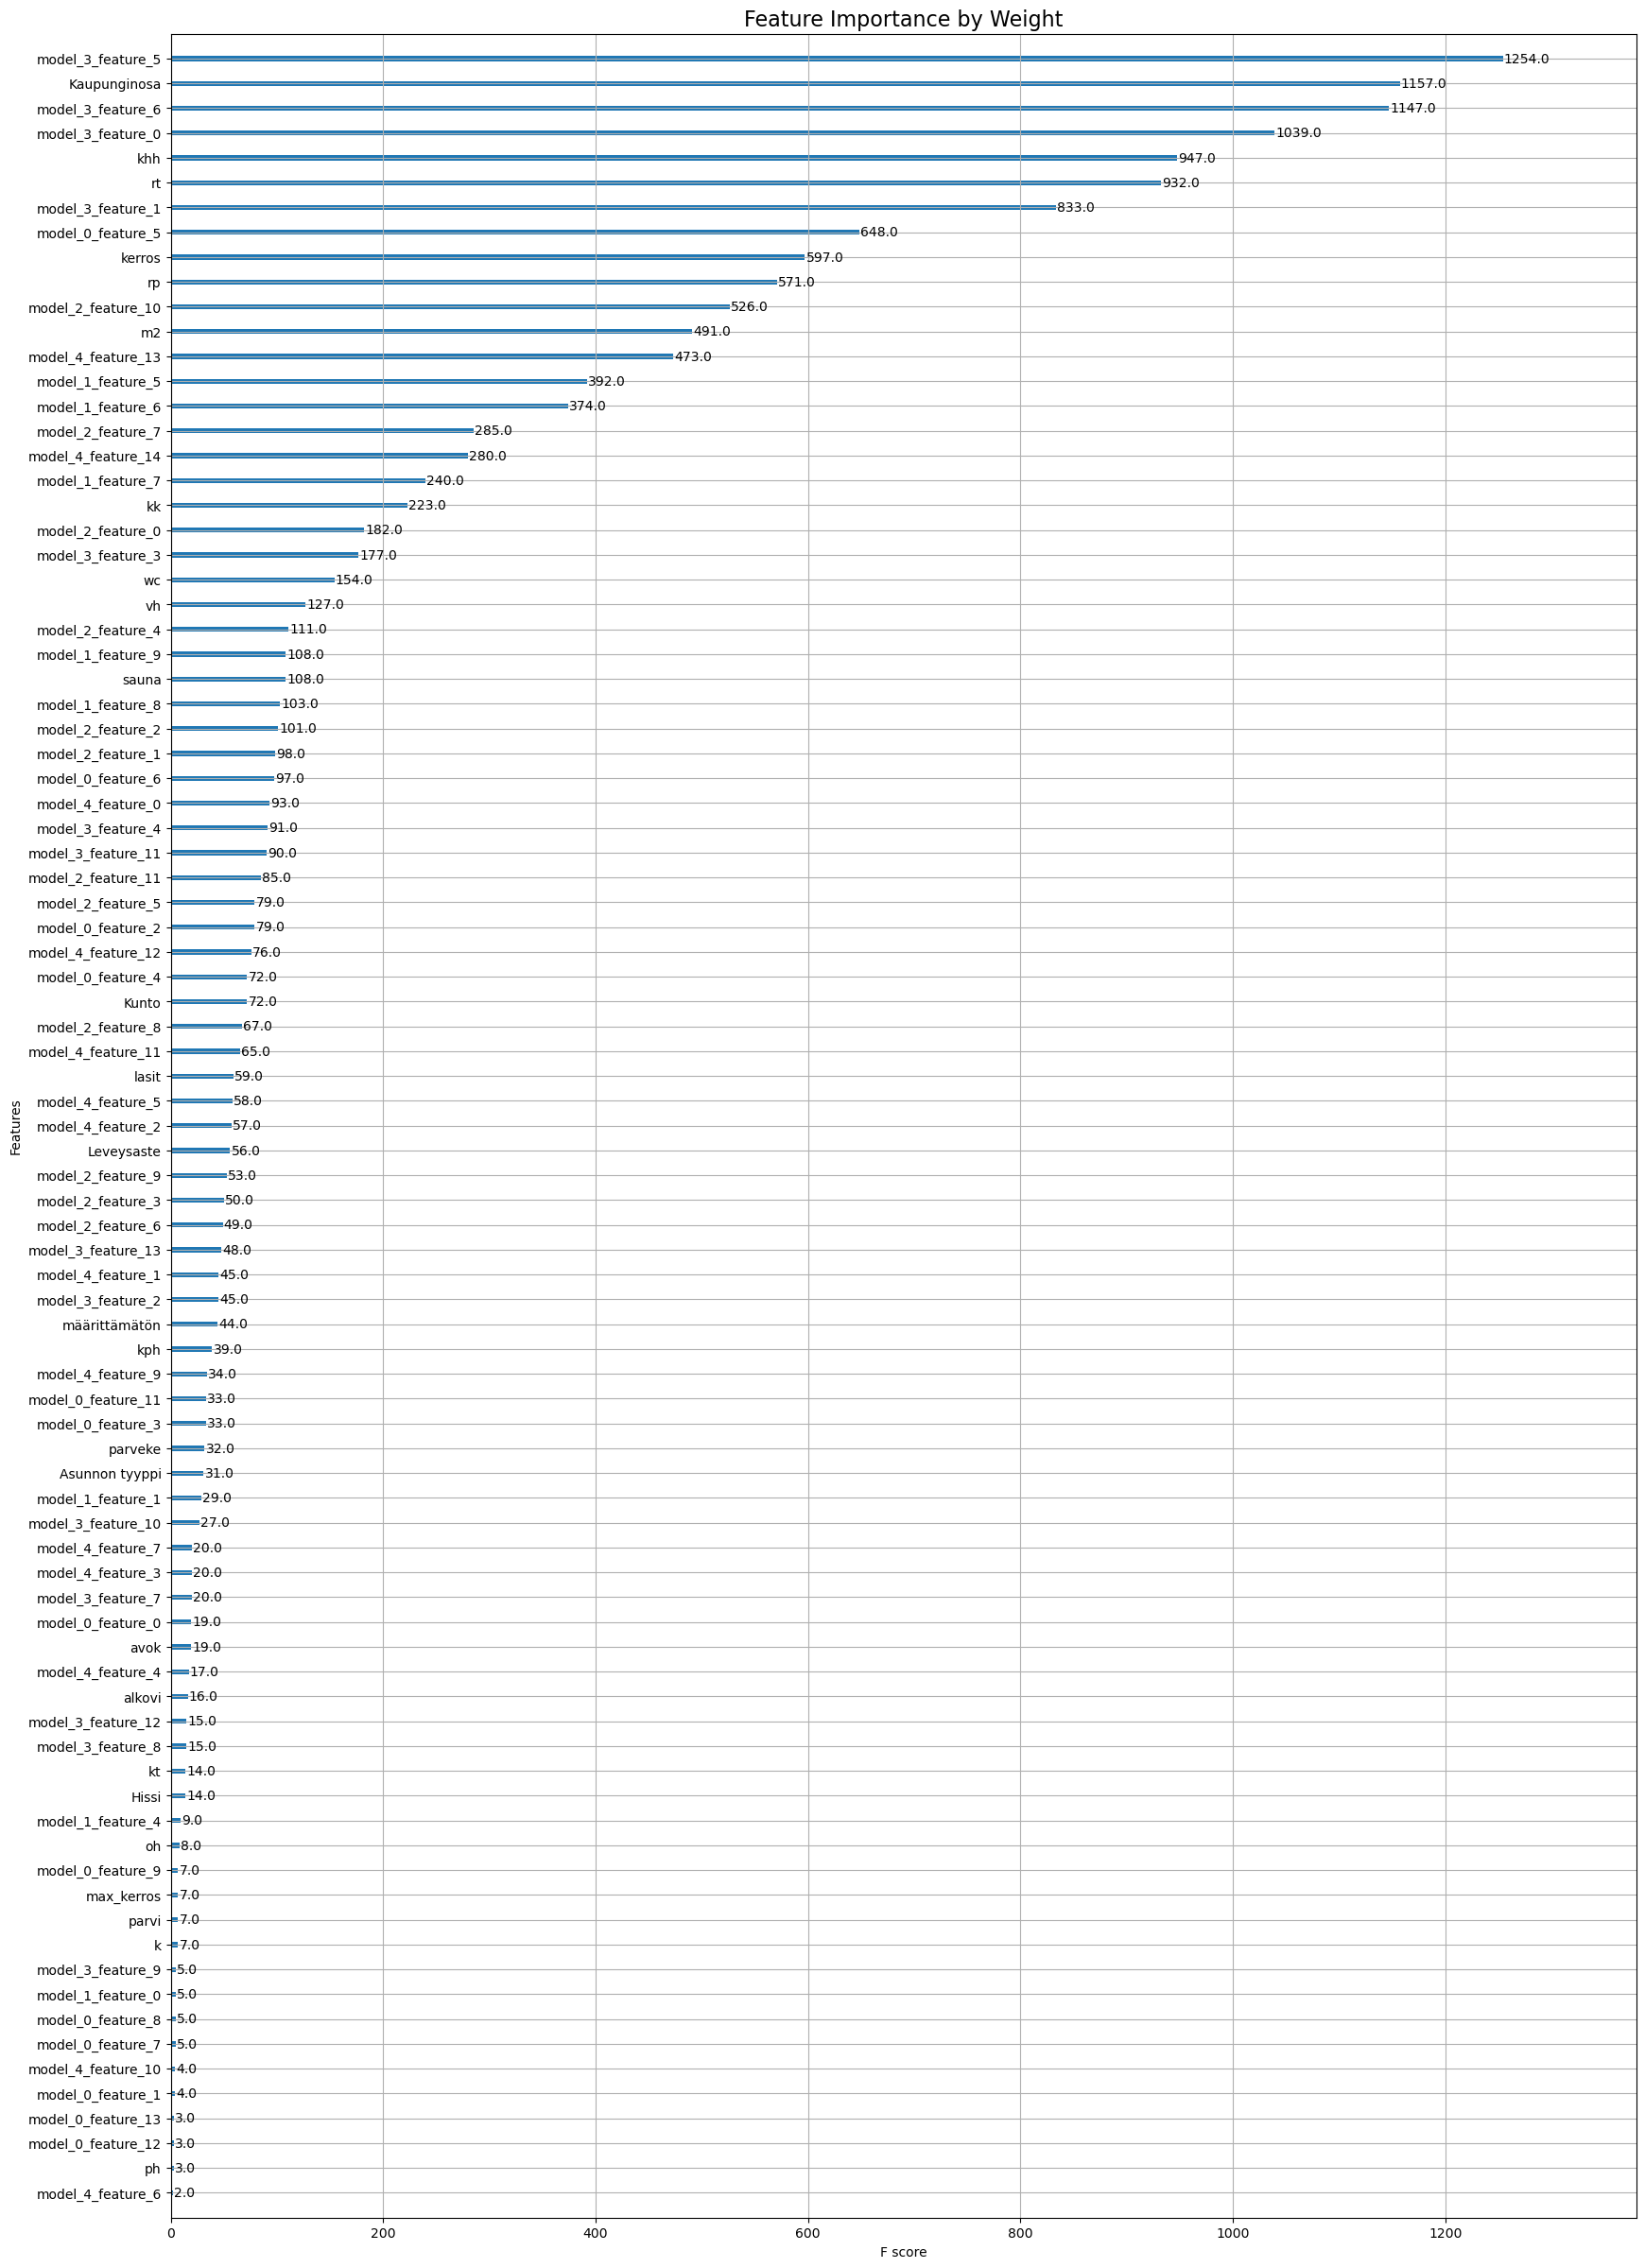

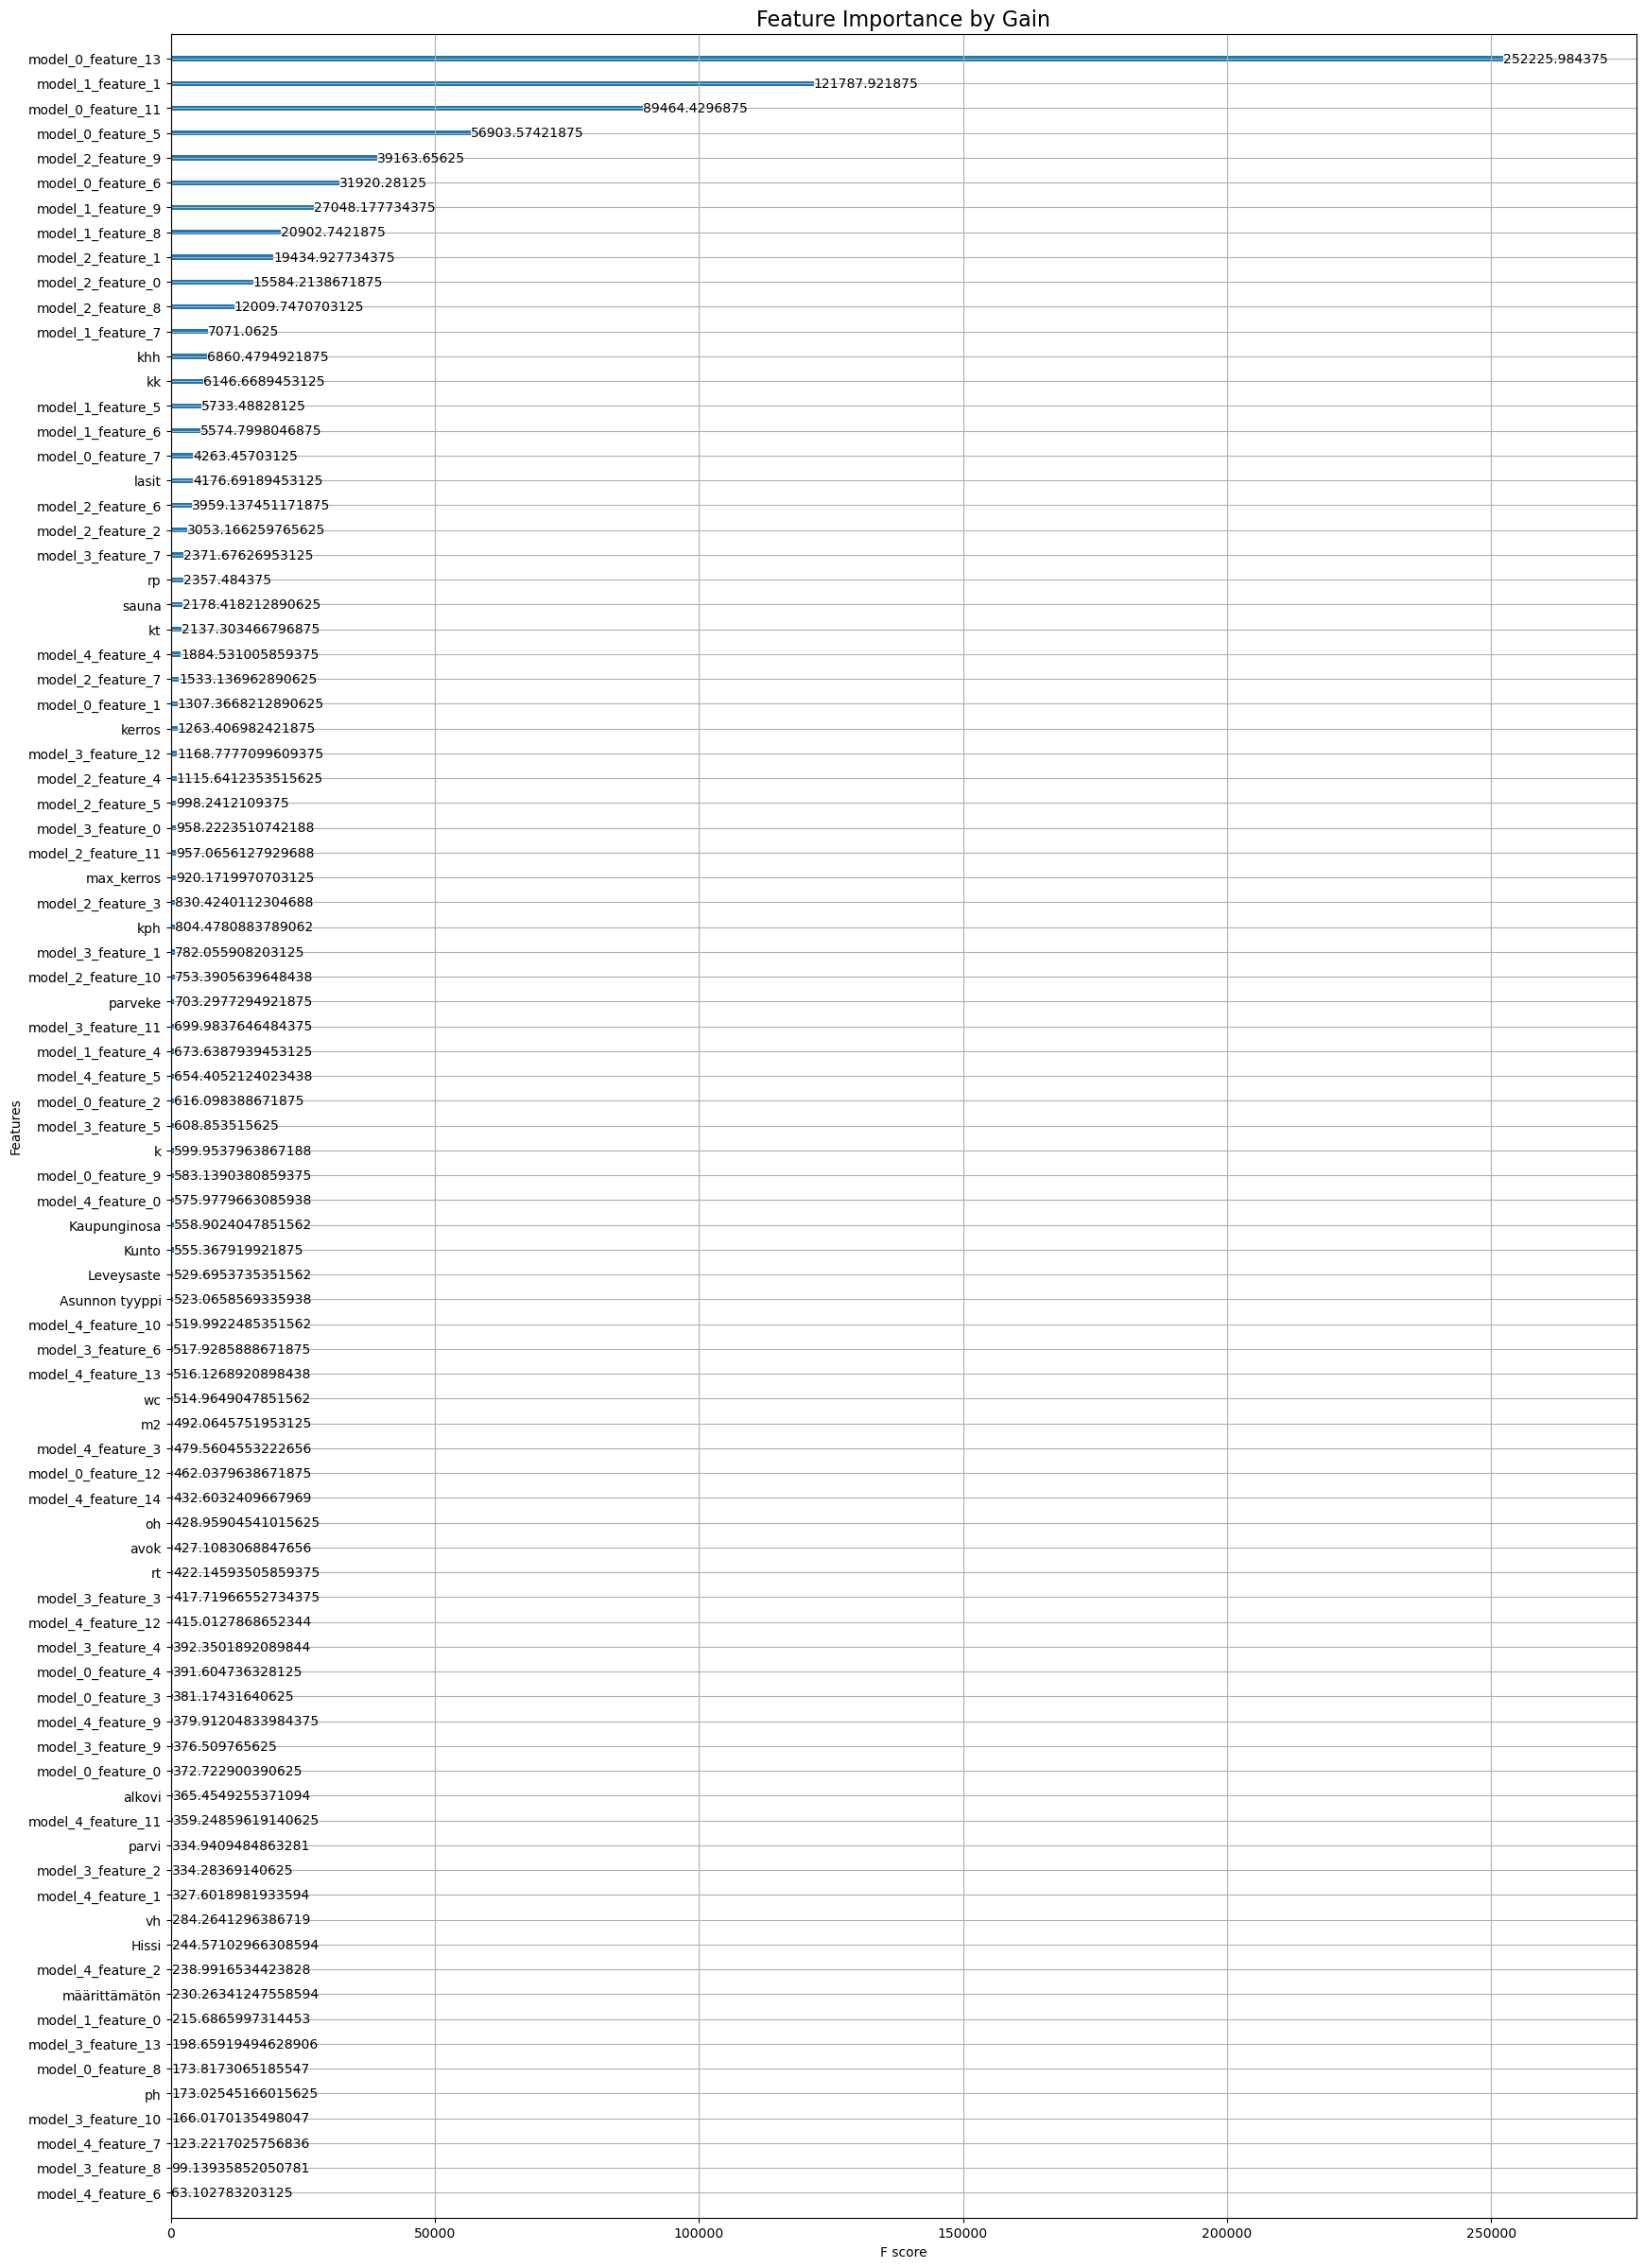

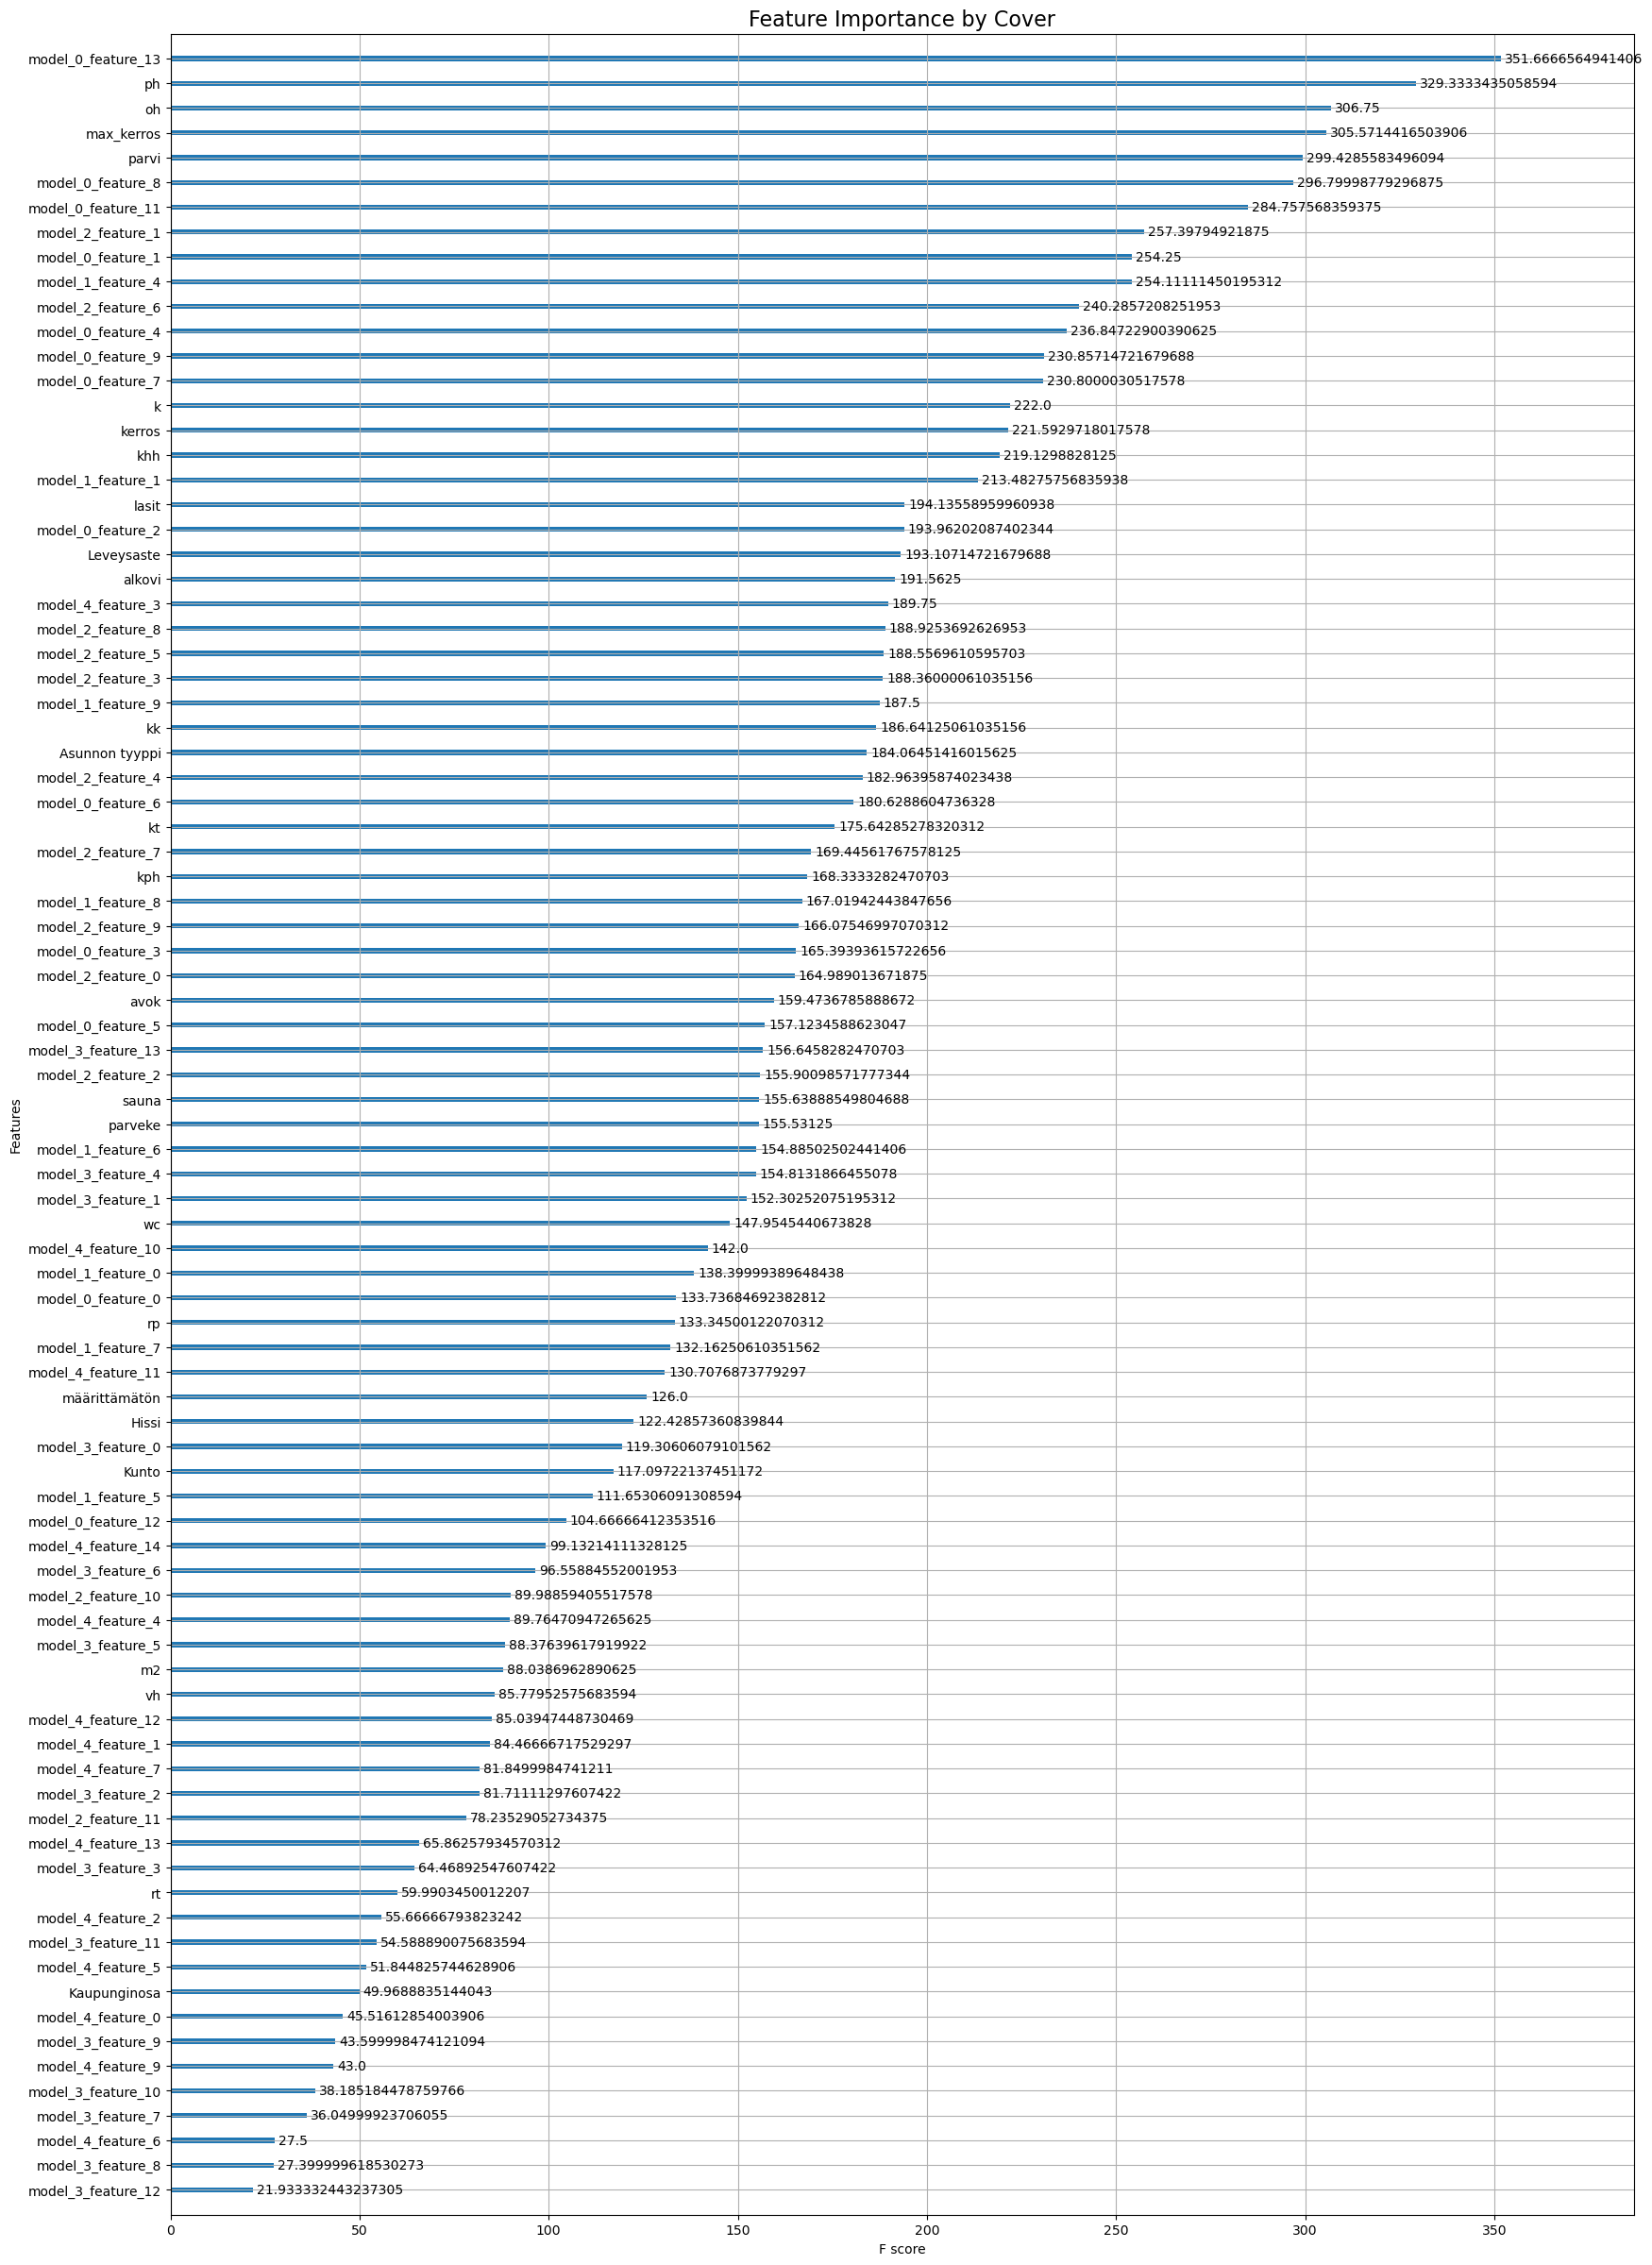

In [16]:
import optuna
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import timedelta
import time
from tensorflow.keras.models import Model
import glob
import pickle

time_started_xgb = time.time()

num_of_trials = 150

# Kerätään ensin kaikkien mallien ominaisuusvektorit
X_train_features_list = []
X_test_features_list = []
features_names_list = []

study_name = 'tampere_rmsle5'  # Korvaa tämä oikealla study_nimellä
from tensorflow.keras.models import load_model

best_optuna_models = []

def rmsle_loss(y_true, y_pred):
    penalty = tf.constant(1e5, dtype=tf.float32)
    valid_mask = tf.math.greater(y_pred, 0.0)
    safe_y_pred = tf.where(valid_mask, y_pred, penalty)
    rmsle = tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(safe_y_pred) - tf.math.log1p(y_true))))
    return tf.where(tf.reduce_any(~valid_mask), penalty, rmsle)

# Kun lataat mallin, määritä mukautettu häviöfunktio custom_objects-parametrissa
custom_objects = {"rmsle_loss": rmsle_loss}


for fold_num in range(folds):
    pattern = f"./NN_search/{study_name}_foldmodel{fold_num}_score_*.h5"  # Oletetaan, että mallit on tallennettu .h5-muodossa
    model_files = glob.glob(pattern)
    
    # Etsi suurin score kunkin foldin mallitiedostoista
    best_score = -float('inf')
    best_model_file = None
    for model_file in model_files:
        score_part = model_file.split('_score_')[1]  # Erottaa score osan tiedostonimestä        
        score = float(score_part.split('_')[0])  # Muuttaa scoren float-arvoksi
        if score > best_score:
            best_score = score
            best_model_file = model_file
    
    # Lataa parhaan mallin tiedosto
    if best_model_file:
        best_model = load_model(best_model_file, custom_objects=custom_objects)
        best_optuna_models.append(best_model)
        print(f"Loaded best model for fold {fold_num} from {best_model_file} with score {best_score:.4f}")
    else:
        print(f"No model files found for fold {fold_num} matching pattern {pattern}")


# best_models_per_fold-listas

original_feature_names = list(X_train.columns) 

for idx, model in enumerate(best_optuna_models):
    feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    X_train_features = feature_extractor.predict(X_train_NN)
    X_test_features = feature_extractor.predict(X_test_NN)
    
    X_train_features_list.append(X_train_features)
    X_test_features_list.append(X_test_features)

    num_features = X_train_features.shape[1]
    model_feature_names = [f"model_{idx}_feature_{feature_idx}" for feature_idx in range(num_features)]
    features_names_list.extend(model_feature_names)

combined_feature_names = original_feature_names + features_names_list

# Yhdistetään ominaisuusvektorit
X_train_combined = np.concatenate(X_train_features_list, axis=1)
X_test_combined = np.concatenate(X_test_features_list, axis=1)

X_train_combined = np.concatenate([X_train_combined, X_train], axis=1)   
X_test_combined = np.concatenate([X_test_combined, X_test], axis=1)

y_train = np.array(y_train)


def rmsle(y_true, y_pred):
    if np.any(y_pred <= 0):
        return 1e6
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))
from sklearn.model_selection import KFold

def objective(trial):
    # Määritetään parametrit, jotka optimoidaan
    param = {
        'objective': trial.suggest_categorical('objective', ['reg:squarederror', 'reg:absoluteerror']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
        'nthread': -2
    }
    num_boost_round = trial.suggest_int('num_boost_round', 1, 1000, log=True)

    # K-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmsle_scores = []

    for train_index, val_index in kf.split(X_train_combined):
        X_train_k, X_val_k = X_train_combined[train_index], X_train_combined[val_index]
        y_train_k, y_val_k = y_train[train_index], y_train[val_index]

        dtrain = xgb.DMatrix(X_train_k, label=y_train_k, feature_names=combined_feature_names)
        dval = xgb.DMatrix(X_val_k, label=y_val_k, feature_names=combined_feature_names)

        evals_result = {}
        bst = xgb.train(param, dtrain, num_boost_round=num_boost_round, evals=[(dval, 'val')], evals_result=evals_result, verbose_eval=False)
        # Käytä paras iteraatio määrä laskemaan ennusteet ja RMSLE
        best_iteration = bst.best_iteration
        preds = bst.predict(dval, iteration_range=(0, best_iteration + 1))
        loss = rmsle(y_val_k, preds)
        rmsle_scores.append(loss)

    average_rmsle = np.mean(rmsle_scores)
    return average_rmsle

study = optuna.create_study(direction='minimize', storage='sqlite:///tampere_reg.db', study_name='tampere_xgb_combined_test_kolmas', load_if_exists=True) # TODO muuta nimeä tarvittaessa
study.optimize(objective, n_trials=num_of_trials)

print(f'Time taken for XGBoost optimization: {str(timedelta(seconds=(time.time() - time_started_xgb)))}')
print(f'Time taken for one trial: {str(timedelta(seconds=(time.time() - time_started_xgb) / num_of_trials))}')

# Parhaiden parametrien tulostus ja mallin koulutus
print(f"Best trial: {study.best_trial.params}")
best_params = study.best_trial.params
dtrain = xgb.DMatrix(X_train_combined, label=y_train, feature_names=combined_feature_names)
best_model = xgb.train(best_params, dtrain, num_boost_round=best_params['num_boost_round'])

# Ennustukset ja evaluointi testidatalla
dtest = xgb.DMatrix(X_test_combined, label=y_test, feature_names=combined_feature_names)
predictions = best_model.predict(dtest)

# Visualisoidaan ennustettuja arvoja verrattuna todellisiin arvoihin
plt.figure(figsize=(20, 10))
plt.scatter(y_test, predictions, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs. Predicted Values')
plt.show()

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmsle_val = rmsle(y_test, predictions)
print(f"MAE: {mae}, MSE: {mse}, R2: {r2}, RMSLE: {rmsle_val}")

fig, ax = plt.subplots(figsize=(20, 30))
xgb.plot_importance(best_model, importance_type='weight', ax=ax)
ax.set_title('Feature Importance by Weight', fontsize=16)
plt.show()

# Asetetaan toisen kuvaajan koko
fig, ax = plt.subplots(figsize=(20, 30))
xgb.plot_importance(best_model, importance_type='gain', ax=ax)
ax.set_title('Feature Importance by Gain', fontsize=16)
plt.show()

# Asetetaan kolmannen kuvaajan koko
fig, ax = plt.subplots(figsize=(20, 30))
xgb.plot_importance(best_model, importance_type='cover', ax=ax)
ax.set_title('Feature Importance by Cover', fontsize=16)
plt.show()


